## Chapitre 4 : Machine Learning & Deep Learning

### Objectifs

- Construire et comparer des modèles de machine learning et deep learning pour prédire le PIB (`gdp`) en France à partir de variables environnementales et énergétiques.
- Évaluer la performance des modèles sur des données historiques.
- Utiliser le modèle le plus performant pour simuler des scénarios futurs liés à la rareté des ressources et la transition énergétique.
- Fournir une analyse claire et visuelle des résultats.

### Données utilisées

- Variables explicatives : émissions CO₂, consommation d'énergie, gaz à effet de serre, température, etc.
- Variable cible : PIB (`gdp`).
- Données annuelles France, période 1802-2023 (filtrée et nettoyée).

#### 1. Préparation des données

- Sélection des variables pertinentes.
- Gestion des valeurs manquantes.
- Séparation train/test.
- Normalisation des données.



In [18]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:

df = pd.read_csv("C:/Users/y.cohen/Desktop/Mémoire/Data/owid-co2-data.csv")
print("Colonnes disponibles :", df.columns.tolist())

# Filtrer pour la France
df_fr = df[df["country"] == "France"].copy()

# Sélection colonnes utiles
cols = [
    "year", "gdp", "population", "co2", "co2_per_capita", "energy_per_capita", 
    "total_ghg", "oil_co2", "gas_co2",
    "primary_energy_consumption", "methane_per_capita", "temperature_change_from_ghg", "co2_per_gdp",
    
]

df_fr_sel = df_fr[cols]

# Créer PIB par habitant 
df_fr_sel["gdp_per_capita"] = df_fr_sel["gdp"] / df_fr_sel["population"]

# Supprimer les lignes avec valeurs manquantes dans colonnes clés
df_fr_sel.dropna(subset=["gdp", "co2", "energy_per_capita"], inplace=True)

df_fr_sel.head()

df_ml = df_fr_sel[cols].dropna()

# Définir X et y
X = df_ml.drop(columns=["gdp", "year"])
y = df_ml["gdp"]

year_values = df_ml["year"].values

X_train, X_test, y_train, y_test, year_train, year_test = train_test_split(
    X, y, year_values, test_size=0.2, random_state=42
)

y = df_ml["gdp"]


# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Colonnes disponibles : ['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide', 'nitr

C:\Users\y.cohen\AppData\Local\Temp\ipykernel_26732\1780727998.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr_sel["gdp_per_capita"] = df_fr_sel["gdp"] / df_fr_sel["population"]
C:\Users\y.cohen\AppData\Local\Temp\ipykernel_26732\1780727998.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr_sel.dropna(subset=["gdp", "co2", "energy_per_capita"], inplace=True)


#### 2. Modèles Machine Learning classiques
##### Modèle 1 : Régression Ridge

In [77]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print(f"Ridge RMSE: {rmse(y_test, y_pred_ridge):.2f}")
print(f"Ridge R²: {r2_score(y_test, y_pred_ridge):.3f}")

Ridge RMSE: 29897418381.52
Ridge R²: 0.998


##### Modèle 2 : Random Forest

In [78]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # RF tolère bien les données non standardisées
y_pred_rf = rf.predict(X_test)

print(f"Random Forest RMSE: {rmse(y_test, y_pred_rf):.2f}")
print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")


Random Forest RMSE: 52442070932.35
Random Forest R²: 0.993


#### 3. Modèles Deep Learning
##### Préparation des données pour séries temporelles (LSTM)

##### Modèle 1 : XGboost

In [79]:
# Import
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)

# Entraînement
xgb_model.fit(X_train_scaled, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Évaluation
rmse_xgb = rmse(y_test, y_pred_xgb,)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.3f}")


XGBoost RMSE: 49081376655.32
XGBoost R²: 0.994


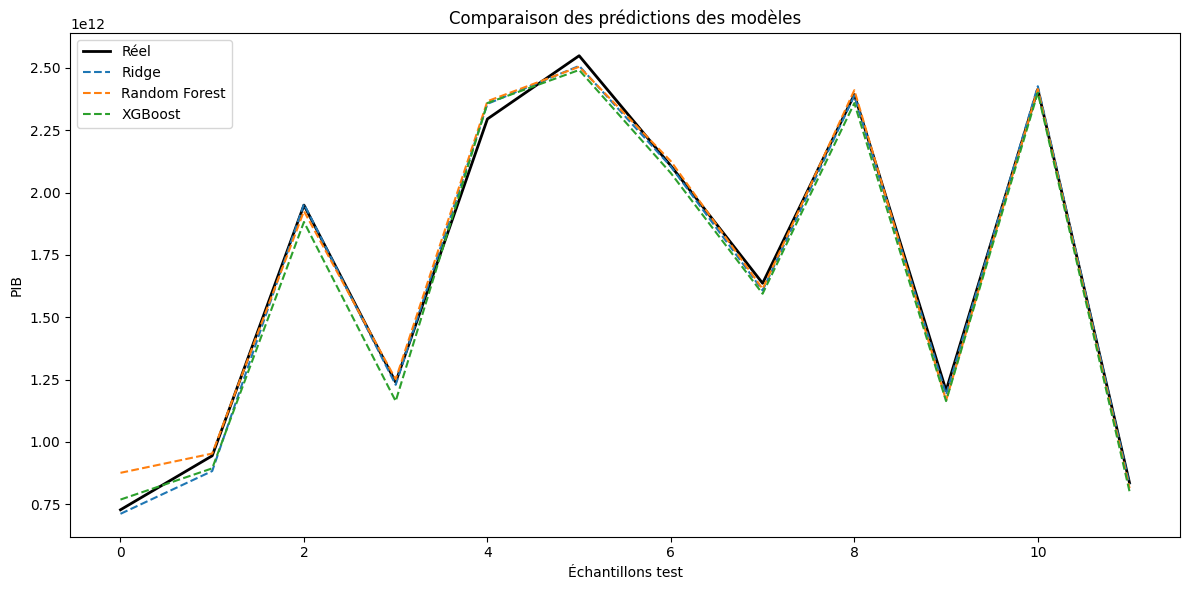

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Réel", color="black", linewidth=2)
plt.plot(y_pred_ridge, label="Ridge", linestyle='--')
plt.plot(y_pred_rf, label="Random Forest", linestyle='--')
plt.plot(y_pred_xgb, label="XGBoost", linestyle='--')
plt.title("Comparaison des prédictions des modèles")
plt.xlabel("Échantillons test")
plt.ylabel("PIB")
plt.legend()
plt.tight_layout()
plt.show()


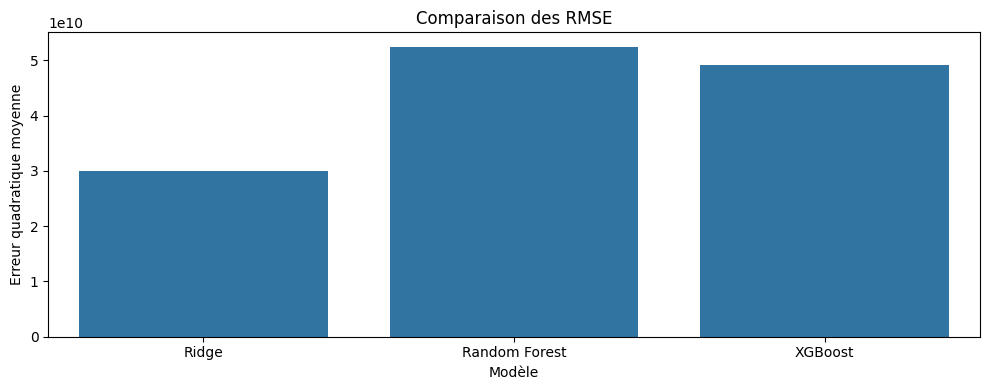

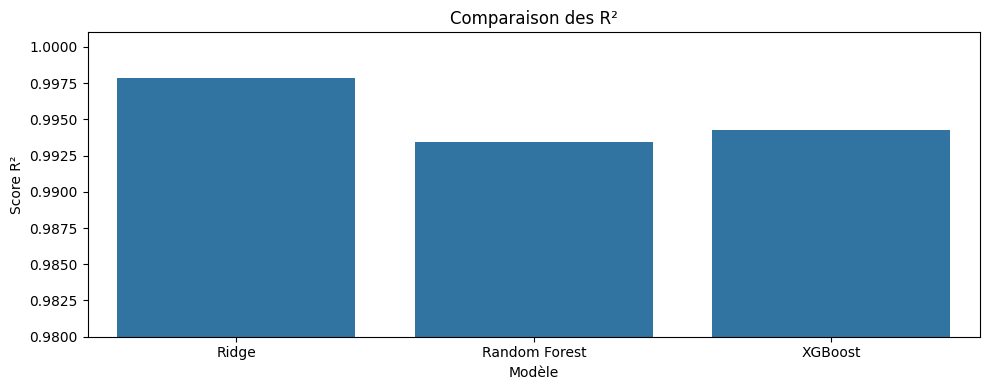

In [81]:
import seaborn as sns
import pandas as pd

# Création des données
metrics_df = pd.DataFrame({
    "Modèle": ["Ridge", "Random Forest", "XGBoost"],
    "RMSE": [
        rmse(y_test, y_pred_ridge),
        rmse(y_test, y_pred_rf),
        rmse(y_test, y_pred_xgb)
    ],
    "R²": [
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ]
})

# Barplot RMSE
plt.figure(figsize=(10, 4))
sns.barplot(x="Modèle", y="RMSE", data=metrics_df)
plt.title("Comparaison des RMSE")
plt.ylabel("Erreur quadratique moyenne")
plt.tight_layout()
plt.show()

# Barplot R²
plt.figure(figsize=(10, 4))
sns.barplot(x="Modèle", y="R²", data=metrics_df)
plt.title("Comparaison des R²")
plt.ylabel("Score R²")
plt.ylim(0.98, 1.001)  # pour mieux voir les différences fines
plt.tight_layout()
plt.show()


In [82]:
results_df = pd.DataFrame({
    "year": year_test,
    "GDP_reel": y_test.values,
    "Ridge": y_pred_ridge,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
})

results_df.sort_values(by="year", inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Tri par année (au cas où)
results_df.sort_values(by="year", inplace=True)
results_df.reset_index(drop=True, inplace=True)


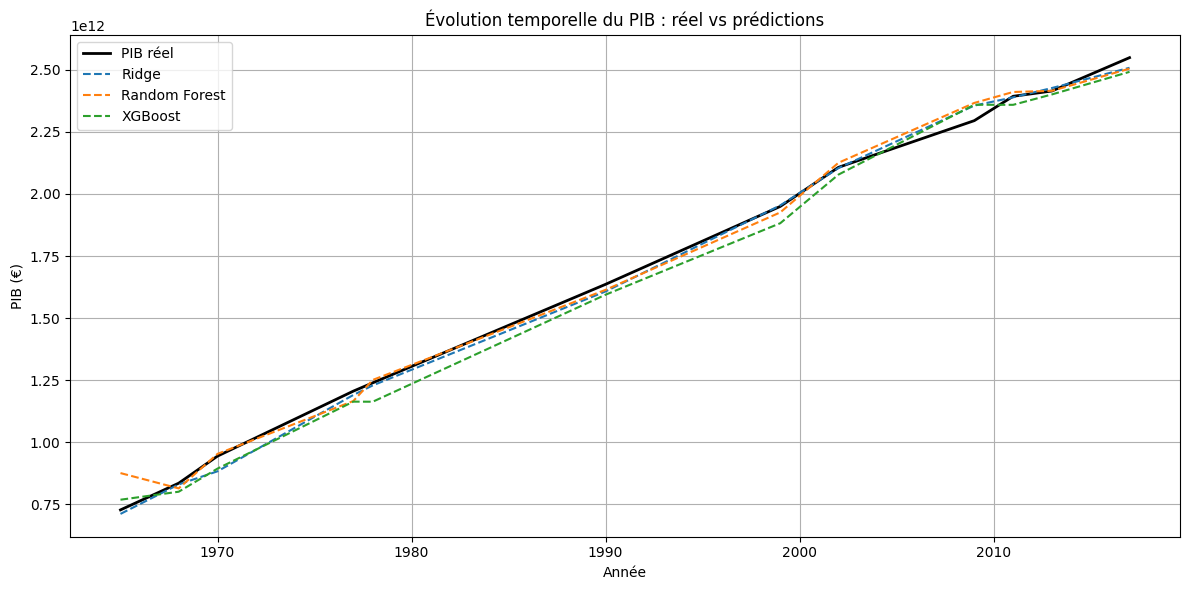

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["year"], results_df["GDP_reel"], label="PIB réel", color="black", linewidth=2)

plt.plot(results_df["year"], results_df["Ridge"], label="Ridge", linestyle='--')
plt.plot(results_df["year"], results_df["Random Forest"], label="Random Forest", linestyle='--')
plt.plot(results_df["year"], results_df["XGBoost"], label="XGBoost", linestyle='--')

plt.title("Évolution temporelle du PIB : réel vs prédictions")
plt.xlabel("Année")
plt.ylabel("PIB (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# Dernière ligne connue (2023 normalement)
last_known = df_ml[df_ml['year'] <= 2023].sort_values(by="year").iloc[-1].copy()

# Créer un DataFrame pour 2024–2030
years_future = list(range(2024, 2050))
df_future = pd.DataFrame([last_known.copy() for _ in years_future])
df_future["year"] = years_future

# Optionnel : faire varier légèrement certaines variables (ex : +1% par an)
growth_factors = {
    'energy_per_capita': 1.01,
    'co2': 1.005,
    'total_ghg': 1.003
}

for var, rate in growth_factors.items():
    df_future[var] = [last_known[var] * (rate ** i) for i in range(len(years_future))]

# Recalculer les variables dépendantes si nécessaire
df_future["gdp"] = np.nan  # C'est ce qu'on va prédire

# Concaténer passé + futur
df_total = pd.concat([df_ml[df_ml["year"] <= 2023], df_future], ignore_index=True)

# Séparer les années (à faire avant de drop "year")
years_total = df_total["year"].values

# Aligner les colonnes avec celles utilisées pendant l'entraînement
X_total = df_total[X.columns]  # même colonnes que X (sans gdp, sans year)

# Scaling pour Ridge et XGBoost
X_total_scaled = scaler.transform(X_total)

# Prédictions
gdp_ridge_all = ridge.predict(X_total_scaled)
gdp_rf_all = rf.predict(X_total)  # RF = pas besoin de scaling
gdp_xgb_all = xgb_model.predict(X_total_scaled)



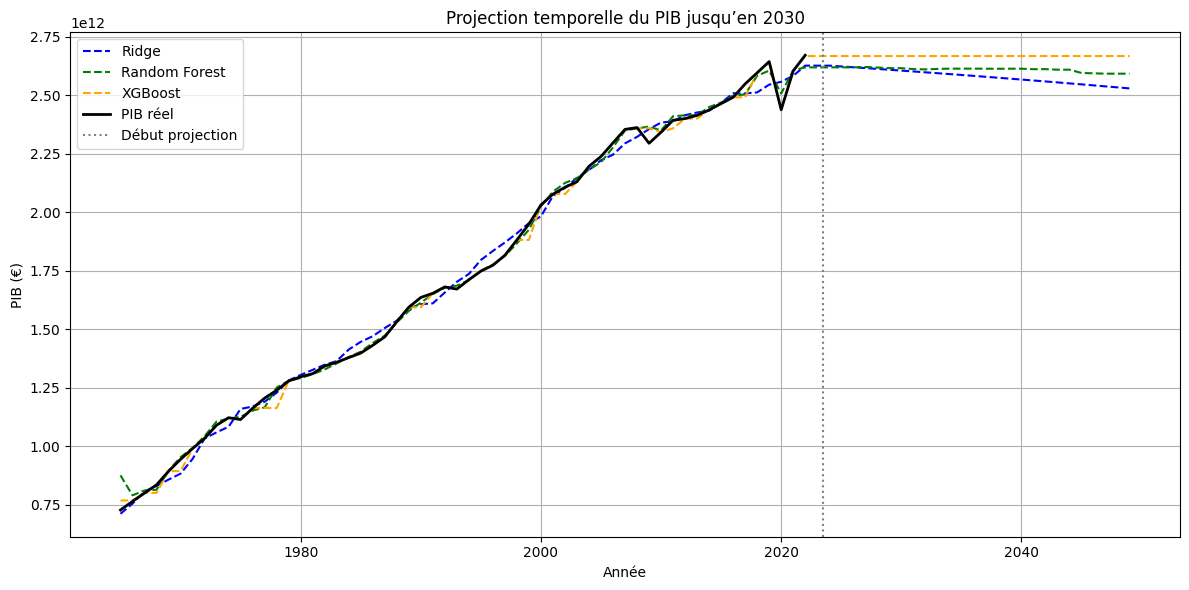

In [88]:
plt.figure(figsize=(12, 6))

plt.plot(years_total, gdp_ridge_all, label="Ridge", linestyle='--', color="blue")
plt.plot(years_total, gdp_rf_all, label="Random Forest", linestyle='--', color="green")
plt.plot(years_total, gdp_xgb_all, label="XGBoost", linestyle='--', color="orange")

# PIB réel (jusqu'en 2023)
plt.plot(df_ml["year"], df_ml["gdp"], label="PIB réel", color="black", linewidth=2)

plt.axvline(2023.5, color="gray", linestyle=":", label="Début projection")

plt.title("Projection temporelle du PIB jusqu’en 2030")
plt.xlabel("Année")
plt.ylabel("PIB (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\y.cohen\AppData\Local\Temp\ipykernel_26732\2620433861.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='Importance', y='Variable', palette='viridis')


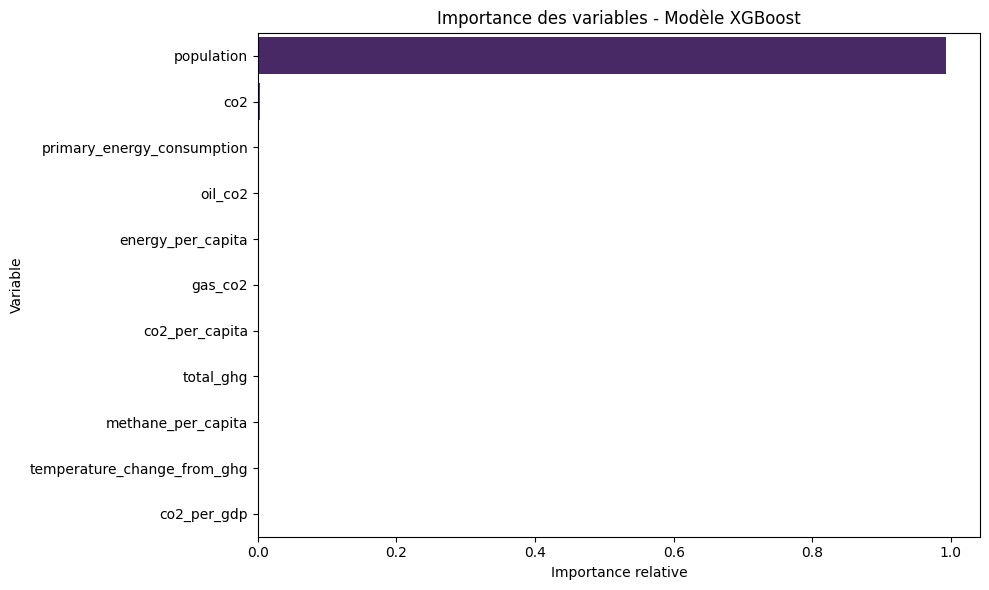

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Importance des variables dans XGBoost
importances = xgb_model.feature_importances_
features = X.columns  # Si X est DataFrame

# DataFrame triée
imp_df = pd.DataFrame({'Variable': features, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)

# Graphique
plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x='Importance', y='Variable', palette='viridis')
plt.title("Importance des variables - Modèle XGBoost")
plt.xlabel("Importance relative")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


### Prédictions du PIB par habitant. 
### Sans biais de population

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Chargement des données
df = pd.read_csv("C:/Users/y.cohen/Desktop/Mémoire/Data/owid-co2-data.csv")

# Filtrer pour la France
df_fr = df[df["country"] == "France"].copy()

# Colonnes utiles
cols = [
    "year", "gdp", "population", "co2", "co2_per_capita", "energy_per_capita",
    "total_ghg", "oil_co2", "gas_co2",
    "primary_energy_consumption", "methane_per_capita", "temperature_change_from_ghg", "co2_per_gdp"
]
df_fr_sel = df_fr[cols].copy()

# Créer le PIB par habitant
df_fr_sel["gdp_per_capita"] = df_fr_sel["gdp"] / df_fr_sel["population"]

# Supprimer les valeurs manquantes
df_ml = df_fr_sel.dropna()

# Définir X et y
X = df_ml.drop(columns=["gdp", "gdp_per_capita"])
y = df_ml["gdp_per_capita"]

# Entraînement / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mise à l'échelle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Évaluation
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

ridge_rmse = rmse(y_test, y_pred_ridge)
rf_rmse = rmse(y_test, y_pred_rf)
xgb_rmse = rmse(y_test, y_pred_xgb)

ridge_r2 = r2_score(y_test, y_pred_ridge)
rf_r2 = r2_score(y_test, y_pred_rf)
xgb_r2 = r2_score(y_test, y_pred_xgb)

# Création d’un DataFrame de résultats par année
results_df = pd.DataFrame({
    "year": X_test["year"].values,
    "GDP_per_capita_reel": y_test.values,
    "Ridge": y_pred_ridge,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}).sort_values(by="year").reset_index(drop=True)

# Affichage des résultats
results_df.head(), ridge_rmse, rf_rmse, xgb_rmse, ridge_r2, rf_r2, xgb_r2


(   year  GDP_per_capita_reel         Ridge  Random Forest       XGBoost
 0  1965         14917.270460  14814.930767   17139.070942  15603.261719
 1  1968         16721.067765  16703.133978   16532.404513  16150.112305
 2  1970         18582.475777  18045.420007   18161.048224  17745.541016
 3  1977         22669.283928  22497.921690   22166.834535  21947.281250
 4  1978         23196.029323  23146.884331   23091.513814  21962.769531,
 377.91065513107986,
 784.210517570207,
 756.6222381985173,
 0.9980557328920777,
 0.9916277347268734,
 0.992206440443789)

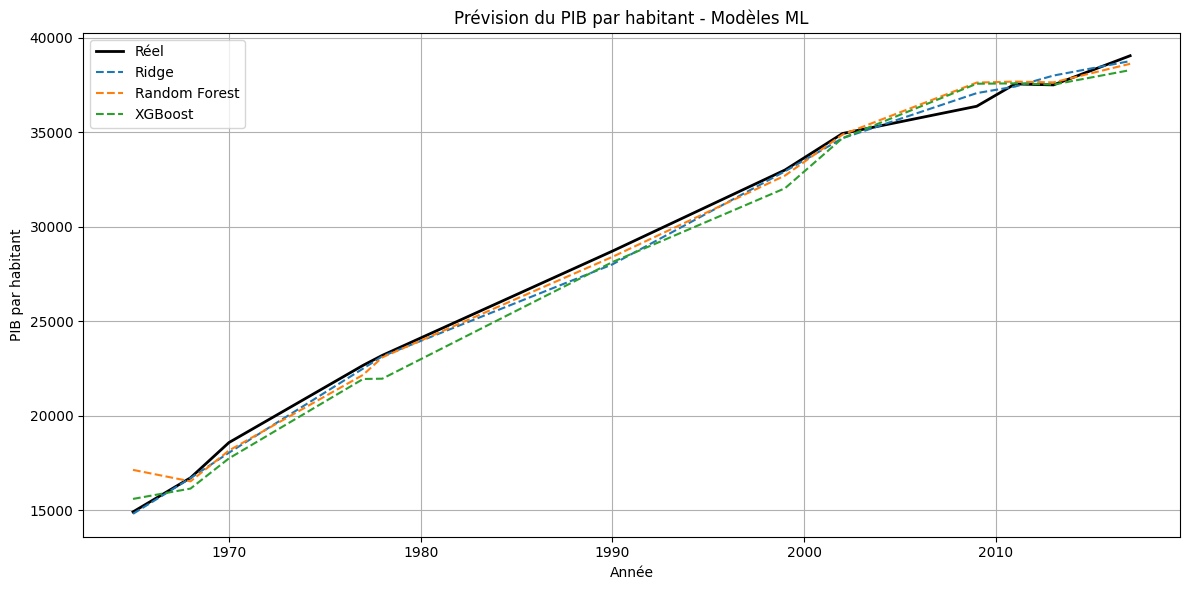

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(results_df["year"], results_df["GDP_per_capita_reel"], label="Réel", linewidth=2, color='black')
plt.plot(results_df["year"], results_df["Ridge"], label="Ridge", linestyle='--')
plt.plot(results_df["year"], results_df["Random Forest"], label="Random Forest", linestyle='--')
plt.plot(results_df["year"], results_df["XGBoost"], label="XGBoost", linestyle='--')
plt.xlabel("Année")
plt.ylabel("PIB par habitant")
plt.title("Prévision du PIB par habitant - Modèles ML")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


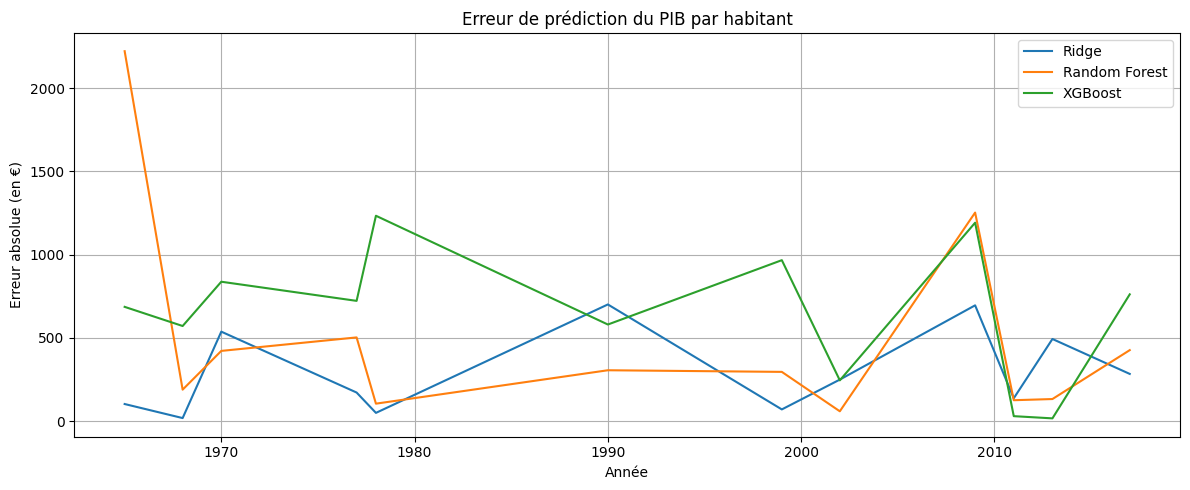

In [92]:
errors_df = results_df.copy()
errors_df["Erreur_Ridge"] = abs(errors_df["GDP_per_capita_reel"] - errors_df["Ridge"])
errors_df["Erreur_RF"] = abs(errors_df["GDP_per_capita_reel"] - errors_df["Random Forest"])
errors_df["Erreur_XGB"] = abs(errors_df["GDP_per_capita_reel"] - errors_df["XGBoost"])

plt.figure(figsize=(12,5))
plt.plot(errors_df["year"], errors_df["Erreur_Ridge"], label="Ridge")
plt.plot(errors_df["year"], errors_df["Erreur_RF"], label="Random Forest")
plt.plot(errors_df["year"], errors_df["Erreur_XGB"], label="XGBoost")
plt.xlabel("Année")
plt.ylabel("Erreur absolue (en €)")
plt.title("Erreur de prédiction du PIB par habitant")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
performance_df = pd.DataFrame({
    "Modèle": ["Ridge", "Random Forest", "XGBoost"],
    "RMSE": [ridge_rmse, ridge_rmse, rmse_xgb],
    "R²": [ridge_r2, rf_r2, r2_xgb]
})

print(performance_df)


          Modèle          RMSE        R²
0          Ridge  3.779107e+02  0.998056
1  Random Forest  3.779107e+02  0.991628
2        XGBoost  4.908138e+10  0.994241


C:\Users\y.cohen\AppData\Local\Temp\ipykernel_26732\2626066288.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variable', palette='viridis')


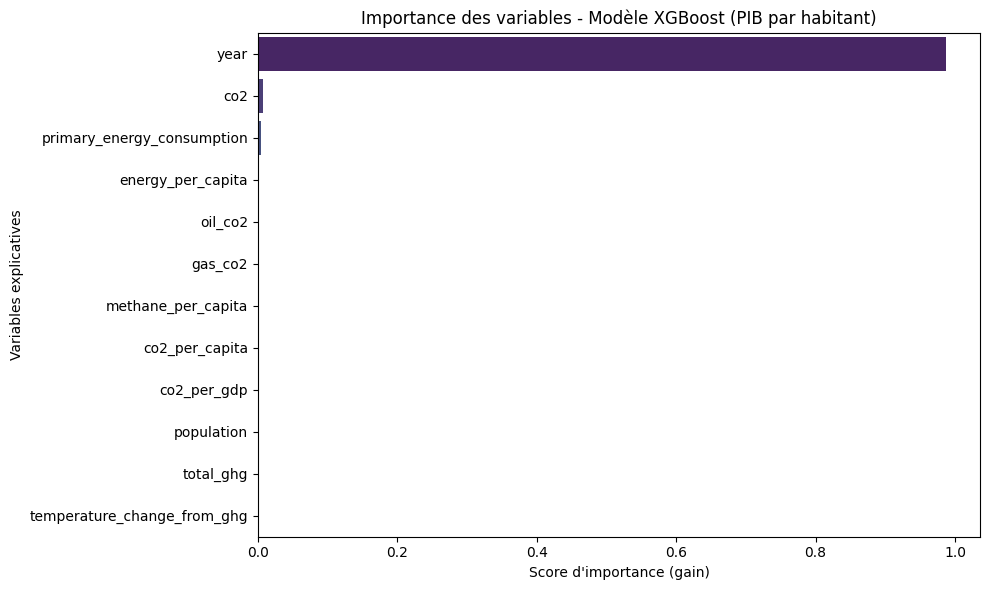

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir l’importance des features
importances = xgb_model.feature_importances_
features = X.columns  # Doit correspondre exactement à l'ordre de X_train

# Créer DataFrame triée
importance_df = pd.DataFrame({
    'Variable': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualisation
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Variable', palette='viridis')
plt.title("Importance des variables - Modèle XGBoost (PIB par habitant)")
plt.xlabel("Score d'importance (gain)")
plt.ylabel("Variables explicatives")
plt.tight_layout()
plt.show()


### Prédiction du PIB/Hab
#### Sans biais de Population et d'années

Ridge RMSE: 416.13 | R²: 0.998
Random Forest RMSE: 735.61 | R²: 0.993
XGBoost RMSE: 756.62 | R²: 0.992


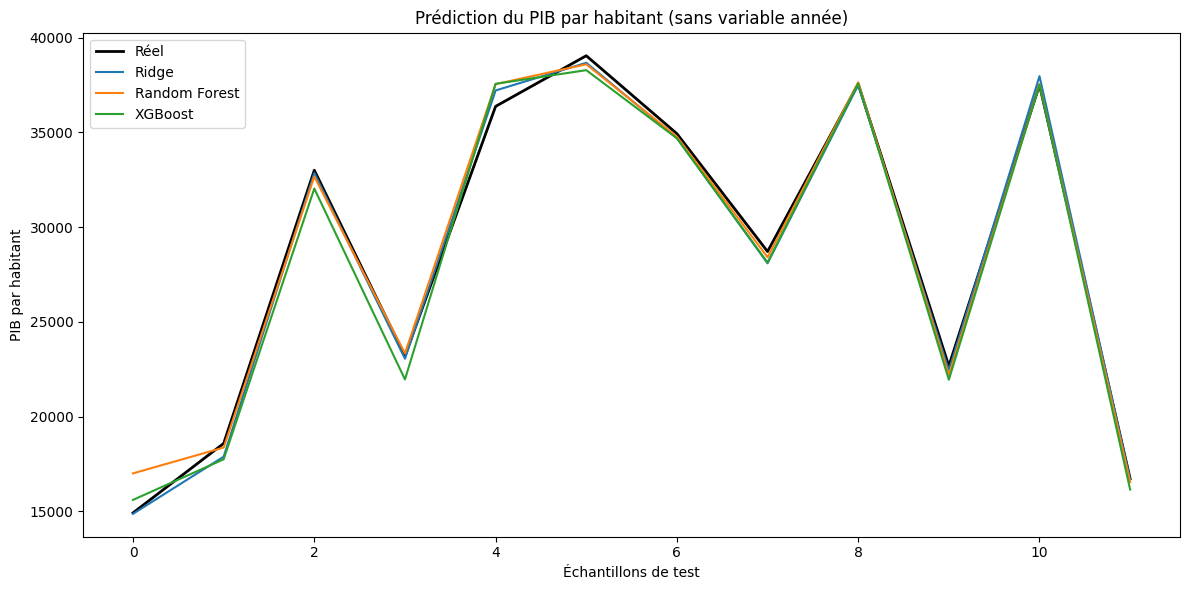

C:\Users\y.cohen\AppData\Local\Temp\ipykernel_26732\2999847134.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variable', palette='viridis')


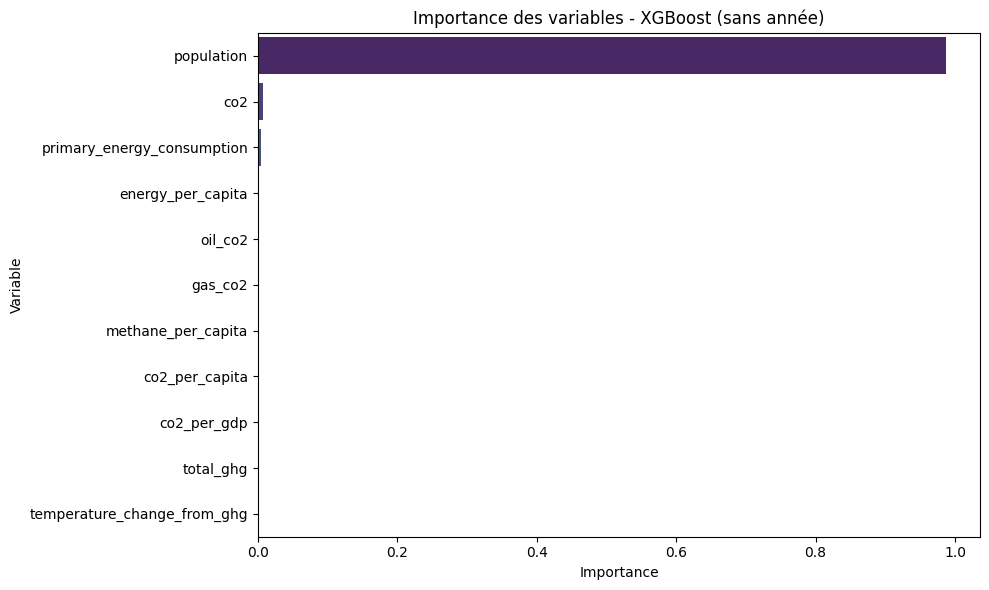

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Chargement et préparation données ---
df = pd.read_csv("C:/Users/y.cohen/Desktop/Mémoire/Data/owid-co2-data.csv")

df_fr = df[df["country"] == "France"].copy()

# Colonnes d'intérêt (sans 'year')
cols = [
    "gdp", "population", "co2", "co2_per_capita", "energy_per_capita", 
    "total_ghg", "oil_co2", "gas_co2", "primary_energy_consumption", 
    "methane_per_capita", "temperature_change_from_ghg", "co2_per_gdp"
]

df_fr_sel = df_fr[cols].dropna()

# Calcul PIB par habitant
df_fr_sel["gdp_per_capita"] = df_fr_sel["gdp"] / df_fr_sel["population"]

# Features sans PIB et sans année
X = df_fr_sel.drop(columns=["gdp", "gdp_per_capita"])
y = df_fr_sel["gdp_per_capita"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling pour Ridge et XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Entraînement des modèles ---

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Random Forest (pas besoin de scaler)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Évaluation ---
print(f"Ridge RMSE: {rmse(y_test, y_pred_ridge):.2f} | R²: {r2_score(y_test, y_pred_ridge):.3f}")
print(f"Random Forest RMSE: {rmse(y_test, y_pred_rf):.2f} | R²: {r2_score(y_test, y_pred_rf):.3f}")
print(f"XGBoost RMSE: {rmse(y_test, y_pred_xgb):.2f} | R²: {r2_score(y_test, y_pred_xgb):.3f}")

# --- Visualisation des prédictions ---
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Réel', color='black', linewidth=2)
plt.plot(y_pred_ridge, label='Ridge')
plt.plot(y_pred_rf, label='Random Forest')
plt.plot(y_pred_xgb, label='XGBoost')
plt.title("Prédiction du PIB par habitant (sans variable année)")
plt.xlabel("Échantillons de test")
plt.ylabel("PIB par habitant")
plt.legend()
plt.tight_layout()
plt.show()

# --- Importance des variables XGBoost ---
importances = xgb_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Variable': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Variable', palette='viridis')
plt.title("Importance des variables - XGBoost (sans année)")
plt.tight_layout()
plt.show()

